# COGS 188 - Final Project

# 2048 Using Reinforcement Learning

## Group members

- Ashley Ho
- Mizuho Fukuda

# Abstract 
This project builds a model that attempts to solve the 2048 game using reinforcement learning. 2048 is a single-player tile puzzle game in which the main objective is to produce a large value tile by merging tiles of powers of 2 by sliding the tiles either up, down, left, or right at each state. We compare a baseline model that randomly chooses a move at each state, with a Deep Q-Network (DQN) model, implemented using Stable-Baselines3, that attempts to imitate human strategies. The evaluation metrics include the average score over 100 games, the standard deviation of the scores, and the highest tile achieved for each game over 100 games. The baseline model achieved an average score of 1050.32, frequently reaching the $128$ tile but rarely progressing beyond $256$. In contrast, the DQN model significantly improved performance with an average score of 1972.32 and more frequent attainment of higher tiles, including a $5\%$ achievement rate of the $512$ tile. These findings highlight the DQN model's capability to navigate the game's dynamics, evidenced by consistently higher scores and more advanced tile achievements. Although the DQN model was ultimately unable to achieve the $2048$ tile, the results highlight the effectiveness of deep reinforcement learning in complex game environments, suggesting potential for further optimization to consistently achieve even higher tiles.

# Background

2048 is a single-player tile-sliding game that is played on a 4x4 grid. The game begins with two tiles labeled either $2$ (with probability $0.9$) or $4$ (with probability $0.1$) at random locations on the grid. At each state, the player can move in one of four directions: up, down, left or right, with each move shifting all current tiles on the board in the specified direction within the bounds of the grid. When two tiles of the same value collide during a move, they merge into a single tile labeled with the sum of the two values. Also, on every move, either a new $2$ tile or $4$ tile appears at a random open cell on the grid with probabilities $0.9$ and $0.1$, respectively. If the grid is full with no more allowable moves, the game is over; note that in situations where the grid is full but one of the four moves allows at least one set of two tiles to merge into one, the game is not over yet. In addition, if the objective $2048$ tile is achieved, the game continues on and the player can attempt to compile tiles even higher than $2048$ until the grid is full with no possible moves available. The general strategy of the game involves maneuvering the tiles in such a way as to combine them to create higher-value tiles, ideally working towards the goal of forming a $2048$ tile. A common tactic employed by players is to keep the highest-value tiles in a specific corner and build up from there, which helps in managing the board more effectively and making higher-value merges easier.

The stochastic nature of 2048 makes it a strong problem to explore using reinforcement learning. In particular, there have been several studies conducted on the effectiveness of reinforcement learning in achieving the desired $2048$ tile by modeling the problem as a Markov Decision Process. One study explored using both deep Q-learning and the beam search algorithm to solve the game, finding that the beam search algorithm, which implemented a heuristic function modeled after human strategy, performed better than the deep Q-learning<a name="Li"></a>[<sup>[1]</sup>](#LiNote). Specifically, the beam algorithm utilized in this paper implemented a heuristic function that modeled a typical human player's strategy of keeping higher-valued tiles towards the corners of the grid, making it easier to merge tiles. Another study utilizes optimistic temporal difference learning, which was able to achieve a $32768$ tile $72\%$ of the time, which well exceeds the objective $2048$ tile<a name="Guei"></a>[<sup>[2]</sup>](#GueiNote). This study also explores the techniques of Monte Carlo tree search and deep Q-learning. In our project, we will be attempting to replicate aspects of the models mentioned in these studies, with an emphasis on Q-learning and deep Q-learning.


# Problem Statement

This project attempts to solve the game 2048 using the Deep Q Network algorithm, where we define 'solving' as reaching a maximum tile of $2048$. The objective for the model is to achieve as high of a tile as possible without losing the game (i.e. getting a full grid with no more allowable moves). The game is quantified as a $4x4$ matrix, with a fixed set of actions available at each state. The performance of the model can be measured by the average score over 100 trials after training, where the score of each trial is calculated by accumulating the merged tile values after each move. In addition, the setup of this game is replicable due its stochasticity and the clearly defined environment.

# Data
Since the game environment of 2048 follows a relatively simple and easily-replicable set of rules, we generated our own data. More specifically, the data will depend on previous sets of actions on a specific board, and thus the only way to train a model would be to generate random tiles at each state. 

The environment implementation is designed to emulate the 2048 game using the OpenAI Gym <a name="gym"></a>[<sup>[4]</sup>](#gymNote) interface, providing a structured setup for reinforcement learning experiments. The `Game2048Env` class defines the environment with a 4x4 grid observation space and four discrete actions representing possible moves (up, down, left, right). It uses the `Game2048` class to manage game mechanics such as tile movement, merging, and the addition of new tiles. The `step` function processes the chosen action, updating the game state, calculating rewards, and checking for termination conditions. Additionally, the environment includes rendering capabilities for visualizing the game state, allowing for easier observation of the model behavior.

The reward after each action is calculated based on various characteristics of the current state as well as improvements from the previous state:
- Base Reward = increase in score (total of merged tiles created by the action)
- Bonus Factor:
    - $+1$ for every value that in the bottom row that is in the top 5 largest values on the board
    - $+log_2(\text{max value on board})$ if the max value of the board is in the left bottom corner
    - $+log_2(\text{max value on board})$ if the current action results in a new max value
    - $+2$ if the bottom row is a gradient with the largest value being the left bottom corner (e.g. [32, 16, 8, 4])
- Penalties:
    - $-(\text{number of nonzero tiles on the board})$ if the number of filled spaces on the board exceeds 12 (¾ of the board)
- Absolute penalties:
    - $-5$ if the action is move up
    - $-5$ if the action is move right and there is at least one empty space on the bottom row of the board
- Game over penalty:
    - $-1000$ if the model loses the game

Thus, the total reward policy is as follows (define $\text{a = action})$: 
<p style="text-align: center;">
$ \text{Total Reward} = 
\   \left\{
\begin{array}{ll}
      -5 & \text{a=Up or (a=Right & bottom row not full)} \\
      -1000 & \text{game ends} \\
      \text{Base Reward * Bonus Factor} & \text{otherwise} \\
\end{array} 
\right. \
$
</p>

In general, these reward mechanisms attempt to adopt human-like strategies in order to maximize its chances of solving the puzzle. In particular, the rewards imitate the popular strategy of keeping the largest number at a specified corner and keeping subsequent large values in either the same column or row as that value, ideally in a gradient fashion. This strategy also discourages moves that would potentially disrupt this structure due to the randomness of the spawning of new tiles. In the case of this model, since we want to keep the largest tile at the left bottom corner, we avoid moving up and right to avoid spawning new tiles in the bottom row. However, we also want the model to prioritize saving the game once the board becomes too crowded.


# Proposed Solution
To address this problem, we propose using a Deep Q-Network (DQN) model, a reinforcement learning algorithm that combines Q-learning with deep neural networks. The baseline model is a simple heuristic-based model that takes random actions at each state to move tiles on the game board. This baseline model provides a point of reference to gauge the performance improvement achieved by the DQN model. The baseline model was implemented using a class-based approach in Python, utilizing NumPy for board manipulations and random action selections.
The DQN model leverages deep learning to approximate the Q-value function, which predicts the expected future rewards for each action given the current state of the game. The DQN algorithm involves the following key steps:

1. Experience Replay: The agent stores its experiences (state, action, reward, next state) in a replay buffer. During training, random batches from this buffer are used to update the Q-network, breaking the correlation between consecutive experiences and improving learning stability.
1. Target Network: A separate target network, which is a delayed copy of the Q-network, is used to compute the target Q-values. This helps to stabilize training by reducing oscillations.
1. Exploration-Exploitation Trade-off: The agent balances exploration (choosing random actions) and exploitation (choosing actions based on learned Q-values) using an epsilon-greedy policy. The exploration rate decreases over time, allowing the agent to progressively focus on exploiting its knowledge.

Due to the dimensional complexity of state-action space, where each move can drastically alter the game board's configuration and future potential actions, traditional heuristic approaches may struggle to capture the long-term dependencies and optimal strategies required to excel in the game. The DQN model is suited for this problem because it leverages deep learning to approximate the Q-value function, effectively handling the high-dimensional state space. By using experience replay and a target network, the DQN model stabilizes training and allows the agent to learn sophisticated strategies through exploration and exploitation. 

The DQN model was implemented using the Stable-Baselines3 library <a name="SB3"></a>[<sup>[5]</sup>](#SB3Note). The `MlpPolicy` was used as the policy network, which consists of multi-layer perceptrons to approximate the Q-values. The hyperparameters of the DQN model that we tune are learning rate, buffer size, batch size, the discount factor (gamma), the target update interval, training frequency, and exploration factors (epsilon).

# Evaluation Metrics

The main evaluation metric that we will utilize is the average score of the games $S_{mean}$ over 100 trials. The average score $S_{mean}$ for a total of $100$ games with $a_i$ actions each is defined as:
    $$S_{mean} = \frac{1}{100} \sum_{i=1}^{100} S_i$$
    $$\text{where }S_i = \sum_{k=1}^{a_i} \text{merged tile values}$$
In other words, the total score for a single game is calculated by summing the new tile values formed by merging at every action, which is the scoring formula given by the official 2048 game. The evaluation metric for a model is the average of this value over all 100 simulated games. This metric provides an overall indication of the agent's performance in its attempt to accomplish the objective of the game.

In addition to this metric, we observe the distribution of maximum tile values achieved by the model over 100 games as a more intuitive measure of the quality of the model. Note that this metric is directly correlated with the score as defined above. However, this is still an interesting statistic to observe since it is a more direct measure in relation to the objective of the game, which is to get as high of a number as possible. For example, if two players both end the game with a $2048$ maximum tile, the results can be considered as equal in practice despite potential differences in total scores. The distribution of maximum tiles is calculated by simply dividing the number of games that achieved a maximum tile of $T$ (where $T$ is any of the values from $2$, $4$, $8$, $16$, etc.) by 100 to get the percentage.

The final metric we use is the standard deviation of the scores over the 100 simulated games. The standard deviation of scores measures the variability or dispersion of the scores achieved by the agent. A lower standard deviation indicates more consistent performance, while a higher standard deviation suggests greater variability. The standard deviation of scores assesses the consistency of the agent's performance across multiple episodes.


# Results

In [7]:
import gymnasium as gym
from env_2048 import Game2048Env
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import numpy as np
import torch
from torch import nn
from IPython.display import display, clear_output, Video

**Baseline Model**

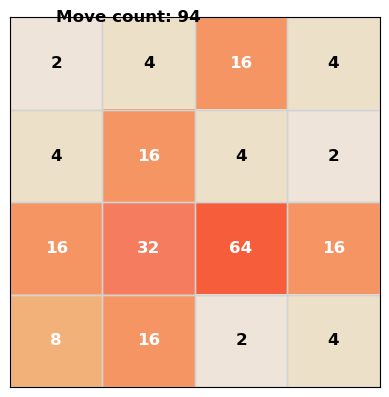

Average Score: 1050.32
Std. Dev. of Scores: 587.0719696936654
Max Tiles Achieved out of 100 episodes: {16: 0.02, 32: 0.12, 64: 0.37, 128: 0.4, 256: 0.09}



In [9]:
env = Game2048Env()
scores = []
max_tiles = {}
for eps in range(100):
    terminated = False
    truncated = False
    observation, _ = env.reset()
    while not terminated or truncated:
        action = env.action_space.sample()  # Take a random action
        observation, reward, terminated, truncated, info = env.step(action)
        moves = {0: 'up', 1: 'down', 2: 'left', 3:'right'}
        if eps == 99:
            env.render(mode='rgb_array')
        if terminated or truncated:
            print(f'\reps {eps + 1}: score - {env.game.score}', end='')
    scores.append(env.game.score)
    if np.max(env.game.board) in max_tiles:
        max_tiles[np.max(env.game.board)] += 1
    else:
        max_tiles[np.max(env.game.board)] = 1
max_tiles = {key : val/100 for (key, val) in max_tiles.items()}
max_tiles = dict(sorted(max_tiles.items()))
print(f'''\rAverage Score: {np.mean(scores)}
Std. Dev. of Scores: {np.std(scores)}
Max Tiles Achieved out of 100 episodes: {max_tiles}
''')


**DQN Model**

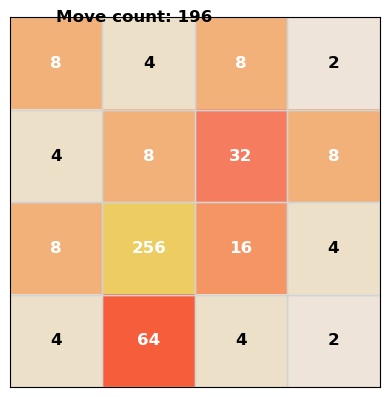

eps 100: score - 2316	
Average Score: 1972.32
Std. Dev. of Scores: 1136.3662339228495
Max Tiles Achieved out of 100 episodes: {32: 0.03, 64: 0.19, 128: 0.4, 256: 0.33, 512: 0.05}



In [10]:
env = Game2048Env()
check_env(env, warn=True)

policy_kwargs = dict(
    net_arch=[256, 256, 256, 256],
    activation_fn=torch.nn.ReLU
)
model = DQN(
    'MlpPolicy',
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=0.0005,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    target_update_interval=500,
    gamma=0.99,
    train_freq=(4, 'step'),
    exploration_fraction=0.4,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.02
    )


model.learn(total_timesteps=500000, log_interval=100)
model.save("dqn_2048")

scores = []
max_tiles = {}

clear_output(wait = True)

for eps in range(100):
    terminated = False
    truncated = False
    obs, _ = env.reset()
    while not terminated or truncated:
        action, _states = model.predict(obs)
        obs, rewards, terminated, truncated, info = env.step(action)
        if eps == 99:
            env.render('rgb_array')
        if terminated or truncated:
            print(f'\reps {eps + 1}: score - {env.game.score}\t', end='')
    scores.append(env.game.score)
    if np.max(env.game.board) in max_tiles:
        max_tiles[np.max(env.game.board)] += 1
    else:
        max_tiles[np.max(env.game.board)] = 1

max_tiles = {key : val/100 for (key, val) in max_tiles.items()}
max_tiles = dict(sorted(max_tiles.items()))
print(f'''
Average Score: {np.mean(scores)}
Std. Dev. of Scores: {np.std(scores)}
Max Tiles Achieved out of 100 episodes: {max_tiles}
''')

**Performance measures over 100 episodes**

| Model | Average Score | Std. Dev. of Scores |
| --- | --- | --- |
| Baseline | 1050.32 | 587.07 |
| DQN | 1972.32 | 1136.37 |

| Max Tile Achieved | Baseline | DQN |
| --- | --- | --- |
| 16 | 2% | 0% |
| 32 | 12% | 3% |
| 64 | 37% | 19% |
| 128 | 40% | 40% |
| 256 | 9% | 33% |
| 512 | 0% | 5% |

In this study, we evaluated the performance of a baseline model and a Deep Q-Network (DQN) model on the 2048 game. The baseline model achieved an average score of 1050.32 with a standard deviation of 587.07, indicating moderate variability in its performance. The highest tiles achieved by the baseline model across 100 episodes are shown in the above table. The baseline model was reasonably consistent in reaching the 128 tile but rarely progressed beyond the 256 tile. In contrast, the DQN model demonstrated a notable improvement in performance. The average score increased to 1972.32, with a higher standard deviation of 1136.37, reflecting a wider range of scores. The DQN model increased the frequency of achieving higher tiles, specifically 256 and 512. 

**Model Hyperparameters**

- In this implementation, the `learning_rate` was set to 0.0005. This relatively low learning rate ensures that the updates to the network's weights are small and gradual, which helps in achieving stable learning and avoiding large oscillations in the training process. 
- The `buffer_size`, set to 100,000 in this model, determines the maximum number of experiences (state, action, reward, next state) that the replay buffer can hold. A larger buffer size allows the model to learn from a more extensive history of past experiences, which can improve the quality of the training data and lead to better generalization. However, a larger buffer also requires more memory and computational resources. The chosen value strikes a balance between having enough experiences to learn from and managing computational efficiency.
- The `learning_starts` is set to 1,000 to ensure that the replay buffer has enough experiences to sample from, providing a diverse set of transitions for training the model. This helps in avoiding overfitting to the initial few experiences and allows the agent to explore the environment sufficiently before starting to learn. 
- The `batch_size` is set to 64. A batch size of 64 is a commonly used value that provides a good trade-off between the stability of the updates and the computational efficiency. 
- The `target_update_interval` is set to 500. Using a target network helps in stabilizing the training by keeping a fixed set of parameters for calculating the target Q-values over multiple updates. The chosen interval of 500 steps ensures that the target network is updated frequently enough to reflect the current policy while maintaining some stability in the training process.
- The discount factor, denoted as `gamma` is set to 0.99. A value of 0.99 indicates that future rewards are slightly less important than immediate rewards but still significantly contribute to the overall expected return. This encourages the agent to consider long-term benefits while making decisions, which is essential for achieving high scores in the 2048 game.
- The `train_freq` parameter is set to (4, 'step'), meaning that the model is trained after every 4 steps taken in the environment. This frequency ensures that the model updates its parameters regularly, allowing for continuous learning and adaptation to the environment.
- The `exploration_fraction` is set to 0.4, indicating that 40% of the training process will involve exploration. 
- The `exploration_initial_eps` is set to 1.0, meaning that the agent starts with complete exploration by selecting actions randomly.
- This value gradually decreases to the `exploration_final_eps` of 0.02, encouraging the agent to exploit its learned policy while still occasionally exploring new actions to avoid local optima.

The policy_kwargs dictionary specifies the architecture and activation function for the neural network used in the DQN model. In this setup, `net_arch=[256, 256, 256, 256]` defines a neural network with four hidden layers, each containing 256 neurons. This deep architecture allows the network to learn complex representations of the game state, which can improve the model's ability to make accurate predictions about the best actions to take. The `activation_fn=torch.nn.ReLU` specifies that the Rectified Linear Unit (ReLU) activation function is used between the layers. ReLU helps mitigate the vanishing gradient problem, allowing the network to train more effectively and converge faster.

Since there are a large number of hyperparameters and many of them depend on each other, we arrived at the above set of hyperparameters by hand-picking the numbers through several trials and errors. Ideally, we would perform a grid-search on each of these parameters to arrive at the highest performing mode. However, since there was limited time and our focus was to tune the reward function, we decided to simply hand-pick the hyperparameter values that seemed suitable.


**Visualization**

The following videos are examples of gameplays using the baseline model and the DQN model.

Baseline Model:

In [11]:
Video("baseline_2048.mp4")

DQN Model:

In [12]:
Video("dqn_2048.mp4")

# Discussion
### Interpreting the result

Observing the rendered animations of the performance of each model, we noticed that although the DQN model does not outperform the baseline model drastically in terms of average score, the efficiency of the two models differ significantly. The tiles colliding with each other in a random fashion can occasionally result in high numbers but this does not happen efficiently and the board tends to be filled with random 2 or 4 tiles that are left unmerged. The DQN model, on the other hand, displays a more efficient gameplay. One can clearly observe the aforementioned strategy of keeping larger numbers at the bottom, which results in the model achieving larger tiles with fewer number of moves.

The comparison between the baseline and DQN models highlights the effectiveness of deep reinforcement learning in solving complex tasks like the 2048 game. The baseline model, likely employing heuristic or simpler strategies, reached its performance limits at lower tiles. In contrast, the DQN model, which leverages deep learning to make more sophisticated decisions, was able to achieve higher scores and more advanced tiles more frequently. The increased standard deviation in the DQN model's scores suggests that while it has a higher potential for better performance, it also experiences greater variability, possibly due to the exploratory nature of the reinforcement learning process.

Overall, these results demonstrate that the DQN model significantly outperforms the baseline model, making it a more effective approach for playing the 2048 game. The ability of the DQN model to achieve higher tiles and scores indicates its capacity to learn and adapt to the game's dynamics better than the baseline model. This suggests that further improvements and fine-tuning of the DQN model could lead to even better performance, potentially achieving the 1024 or 2048 tiles more consistently.


### Limitations

While the implementation of a Deep Q-Network (DQN) model for the 2048 game demonstrates notable improvements over the baseline model, there are several limitations to this work.

The 2048 game has a highly complex state-action space, where each move can drastically alter the game board's configuration. Even with the advanced capabilities of the DQN model, the vast number of possible states and actions poses significant challenges. The DQN struggles to fully capture and optimize long-term strategies required to consistently achieve the highest tiles, such as 1024 or 2048. This complexity can lead to suboptimal decision-making and variability in performance.

In addition, the performance of the DQN model is highly sensitive to its hyperparameters, such as the learning rate, exploration-exploitation parameters, and network architecture. Due to time and computational constraints, the exploration of hyperparameter space was limited. A more exhaustive search or the use of hyperparameter optimization techniques, such as grid search or Bayesian optimization, could potentially yield better-performing models.

Finally, while the DQN model shows promise, more advanced reinforcement learning algorithms, such as Double DQN, Dueling DQN, or Actor-Critic methods, and using a custom defined convolutional neural network (CNN) as the DQN’s policy, could be explored to further enhance performance. These models address some of the limitations inherent in standard DQNs and may offer improved learning efficiency and stability.


### Ethics & Privacy

We anticipate minimal issues regarding ethics and privacy with this project. Since we did not use any outside data, it will not infringe on any personal privacy. In addition, since 2048 is a single player game, even if the model is used to cheat on the game, it will not affect other players. The official 2048 game itself was created by Italian web developer Gabriele Cirulli and is a free and open-source software. Thus, for the purposes of this project, there is no risk of copyright infringement. Any outside sources used in this project to simulate the game environment as well as for building the model will be clearly indicated and included in the reference section.

However, it is essential to recognize that most machine learning (ML) projects have potential ethical implications, even if they are not immediately apparent. While this project focuses on a game, the techniques and methodologies developed could be applied to other domains with more significant ethical implications. In addition, although our current project does not use personal data, it's crucial to ensure that the algorithms we develop do not perpetuate biases. In other applications, reinforcement learning algorithms must be carefully monitored to prevent biased decision-making that could harm individuals or groups.

### Conclusion

This study demonstrates the significant advantages of using Deep Q-Networks (DQN) over baseline heuristic models for playing the 2048 game. Our results clearly show that the DQN model achieves higher scores and reaches more advanced tiles, indicating its ability to learn and adapt to the game's dynamics based on specified reward policies. This highlights the effectiveness of deep reinforcement learning in solving complex, strategic tasks, aligning with similar findings in the field of game AI research.

In the context of existing work, our project adds to the growing body of evidence that deep learning techniques can outperform traditional methods in various game-playing scenarios. The variability in the DQN model’s performance suggests that further fine-tuning and exploration of hyperparameters could yield even better results.

Future work could involve experimenting with more advanced reinforcement learning algorithms, such as Double DQN or Actor-Critic methods, to enhance stability and performance. Additionally, applying transfer learning techniques might help leverage knowledge from other similar games to improve performance in 2048. By continuing to refine these models, we can contribute to broader applications of AI in strategic decision-making and complex problem-solving.


# Footnotes
<a name='Li'></a>1.[^](#LiNote): Li, S., and Peng, V. (20 Oct 2021) Playing 2048 with Reinforcement Learning. *arXiv.Org*. https://doi.org/10.48550/arXiv.2110.10374 <br> 

<a name=”Guei”></a>2.[^](#GueiNote): Guei, H. (21 Dec 2022) On Reinforcement Learning for the Game of 2048. *arXiv.Org*. https://doi.org/10.48550/arXiv.2212.11087 <br>

<a name="model"></a>3.[^](#modelNote): Virdee, N. (2018) 2048-Deep-Reinforcement-Learning. https://github.com/navjindervirdee/2048-deep-reinforcement-learning<br>

<a name='gym'></a>4.[^](#gymNote): Gymnasium Documentation. Retrieved June 12, 2024, from https://gymnasium.farama.org/<br> 

<a name="SB3"></a>5.[^](#SB3Note): Stable-Baselines3 Documentation. Retrieved June 12, 2024, from https://stable-baselines3.readthedocs.io/en/master/